In [1]:
from matplotlib import pyplot as plt
from tabulate import tabulate
import numpy as np
import cv2

In [2]:
# Steps

N = 512
G = 32
P = 50
D = 0.35

T_STEP = int(P / 50) + 1
I_STEP = int(N / 100) + 1

%run -i ./ownlib/PHT-Library.ipynb
%run -i ./ownlib/RIW-Library2.ipynb
%run -i ./ownlib/Utility.ipynb
%run -i ./ownlib/Inverse-Geometric.ipynb

In [3]:
# Import images
ori_img = cv2.imread('./assets/lena.png') #BGR
ori_logo = cv2.imread('./assets/paperplane.png', 0)

In [4]:
def ecute(n, g, p, d):
    # Preprocess Image
    IMG_BGR = cv2.resize(ori_img, (n, n)) # Original Image
    IMG_Y = getYFromBGR(IMG_BGR) #

    # Preprocess Logo
    LOGO = cv2.resize(ori_logo, (g,g))
    LOGO = (LOGO >= 128) * 1
    
    # Scrambling Logo
    LOGO_SC = scramble(LOGO)
    
    # Transform
    MOMEN = transformPHT(IMG_Y, n, p, 'Transform Image, N={} G={} P={} D={}'.format(n, g, p, d))
    
    # Embedding
    QQ = np.floor(np.abs(MOMEN) / d) % 2
    (LOGO_POSITIONED, LOGO_FILTER, maxCapacity) = watermarkEmbed(LOGO, p)
    
    # Calculate Momen Changes
    XI = np.abs(MOMEN) - np.floor(np.abs(MOMEN) / d) * d
    OMEGA = - XI
    OMEGA = OMEGA + d / 2 * (QQ == LOGO_POSITIONED)
    OMEGA = OMEGA + 3 * d / 2 * np.logical_and(QQ != LOGO_POSITIONED, np.logical_or(XI > d / 2, np.abs(MOMEN) < d))
    OMEGA = OMEGA - d / 2 * np.logical_and(QQ != LOGO_POSITIONED, np.logical_and(XI <= d / 2, np.abs(MOMEN) >= d))
    OMEGA = OMEGA / (np.abs(MOMEN) + 0.000000001) * MOMEN
    OMEGA = OMEGA * LOGO_FILTER
    
    # Compensation Image
    IMG_COMPENSATION = inversePHT(OMEGA, n, p, 'Generating Compensation Image N={} G={} P={} D={}'.format(n, g, p, d))
    
    # Watermarking
    IMG_Y_WATERMARKED = IMG_Y + IMG_COMPENSATION
    IMG_WATERMARKED = putYToBGR(IMG_Y_WATERMARKED, IMG_BGR)
    
    # Calculate PSNR
    DST = (IMG_WATERMARKED - IMG_BGR)
    DST = DST * DST
    MSE = np.sum(DST) / (9 * n * n)
    PSNR = 10 * np.log10(255 * 255 / MSE)
    
    # Return
    return (IMG_WATERMARKED, PSNR, n, g, p, d)

In [16]:
def war(image, n):
    attackedImages = []
    
    # No Attack
    attackedImages.append((np.copy(image), 'No Attack'))
    
    # Attack: Rotation
    ROTATION_ANGLE = 45
    imgRotate = attackRotation(image, ROTATION_ANGLE)
    attackedImages.append((imgRotate, 'Rotation {}° CW'.format(ROTATION_ANGLE)))
    
    # Attack: Scaling
    RESIZE_FACTOR = 0.75
    imgResize = attackResize(image, int(RESIZE_FACTOR * n))
    attackedImages.append((imgResize, 'Scaling ' + '{:.0%}'.format(RESIZE_FACTOR)))
    
    # Attack: Translation
    TR_X = 0.05
    TR_Y = -0.05
    imgTranslate = attackTranslate(image, TR_X, TR_Y)
    attackedImages.append((imgTranslate, 'Translation X={:.0%} Y={:.0%}'.format(TR_X, TR_Y)))
    
    # Attack: Crop
    CROP_PERCENTAGE = 0.05
    imgCrop = attackCrop(image, CROP_PERCENTAGE, CROP_PERCENTAGE, CROP_PERCENTAGE, CROP_PERCENTAGE)
    attackedImages.append((imgCrop, 'Crop {:.0%}'.format(CROP_PERCENTAGE)))
    
    # Attack: BLUR
    BLUR_KERNEL_SIZE = 3
    imgBlur = attackBlur(image, BLUR_KERNEL_SIZE)
    attackedImages.append((imgBlur, 'Blur K={}'.format(BLUR_KERNEL_SIZE)))

    # Attack: Black & Pepper Noise
    NOISE_PERCENTAGE = 0.05
    imgNoise = attackRandomNoise(image, NOISE_PERCENTAGE)
    attackedImages.append((imgNoise, 'Noise {:.0%}'.format(NOISE_PERCENTAGE)))

    # Attack: JPG Compression
    COMPRESSION_QUALITY = 60
    imgJpg = attackJPG(image, ROTATION_ANGLE)
    attackedImages.append((imgJpg, 'JPG Compression Q={}'.format(COMPRESSION_QUALITY)))
    
    return attackedImages

In [6]:
# Test

(watermarkedImage, psnr, n, g, p, d) = ecute(N, G, P, D)

clear_output(wait = True)
print(tabulate([[n, g, p, d, psnr]], headers=['N', 'G', 'P', 'D', 'PSNR'], tablefmt='orgtbl'))

|   N |   G |   P |    D |    PSNR |
|-----+-----+-----+------+---------|
| 512 |  32 |  50 | 0.35 | 35.5143 |


In [17]:
imgAttackedList = war(watermarkedImage, n)
extractedLogos = [None]*20
extractedBers = [None]*20
attackedImages = [None]*20
attackTitles = [None]*20

BER = 0%


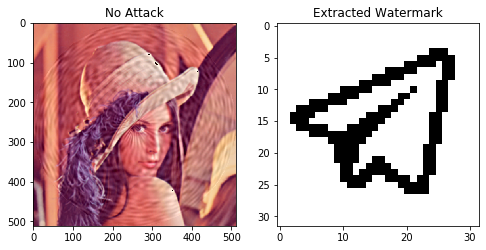

In [8]:
index = 0
(attackedImages[index], attackTitles[index]) = imgAttackedList[index]
(extractedLogos[index], extractedBers[index]) = extractWatermarkFromImage(attackedImages[index], ori_img, ori_logo, n, g, p, d, 'N={} G={} P={} D={}\n{}'.format(n, g, p, d, attackTitles[index]))

clear_output(wait = True)
print('BER = {:.0%}'.format(extractedBers[index]))
imgshow([[attackedImages[index], extractedLogos[index]]], [[attackTitles[index], 'Extracted Watermark']])

BER = 11%


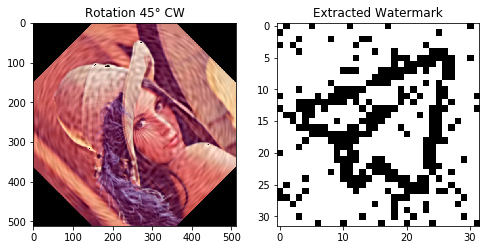

In [18]:
index = 1
(attackedImages[index], attackTitles[index]) = imgAttackedList[index]
(extractedLogos[index], extractedBers[index]) = extractWatermarkFromImage(attackedImages[index], ori_img, ori_logo, n, g, p, d, 'N={} G={} P={} D={}\n{}'.format(n, g, p, d, attackTitles[index]))

clear_output(wait = True)
print('BER = {:.0%}'.format(extractedBers[index]))
imgshow([[attackedImages[index], extractedLogos[index]]], [[attackTitles[index], 'Extracted Watermark']])

BER = 0%


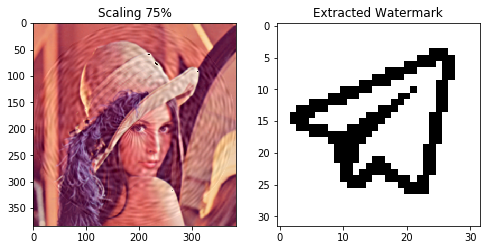

In [10]:
index = 2
(attackedImages[index], attackTitles[index]) = imgAttackedList[index]
(extractedLogos[index], extractedBers[index]) = extractWatermarkFromImage(attackedImages[index], ori_img, ori_logo, n, g, p, d, 'N={} G={} P={} D={}\n{}'.format(n, g, p, d, attackTitles[index]))

clear_output(wait = True)
print('BER = {:.0%}'.format(extractedBers[index]))
imgshow([[attackedImages[index], extractedLogos[index]]], [[attackTitles[index], 'Extracted Watermark']])

BER = 15%


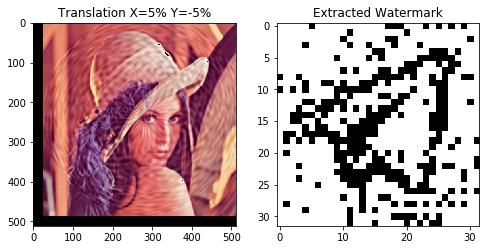

In [11]:
index = 3
(attackedImages[index], attackTitles[index]) = imgAttackedList[index]
(extractedLogos[index], extractedBers[index]) = extractWatermarkFromImage(attackedImages[index], ori_img, ori_logo, n, g, p, d, 'N={} G={} P={} D={}\n{}'.format(n, g, p, d, attackTitles[index]))

clear_output(wait = True)
print('BER = {:.0%}'.format(extractedBers[index]))
imgshow([[attackedImages[index], extractedLogos[index]]], [[attackTitles[index], 'Extracted Watermark']])

BER = 8%


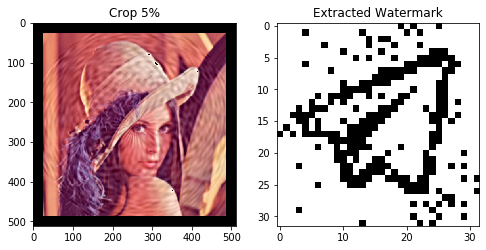

In [12]:
index = 4
(attackedImages[index], attackTitles[index]) = imgAttackedList[index]
(extractedLogos[index], extractedBers[index]) = extractWatermarkFromImage(attackedImages[index], ori_img, ori_logo, n, g, p, d, 'N={} G={} P={} D={}\n{}'.format(n, g, p, d, attackTitles[index]))

clear_output(wait = True)
print('BER = {:.0%}'.format(extractedBers[index]))
imgshow([[attackedImages[index], extractedLogos[index]]], [[attackTitles[index], 'Extracted Watermark']])

BER = 0%


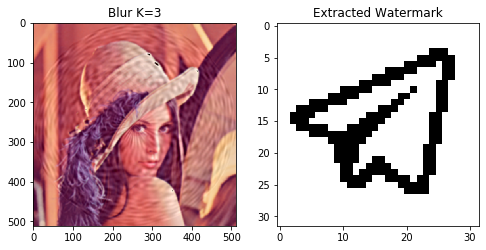

In [13]:
index = 5
(attackedImages[index], attackTitles[index]) = imgAttackedList[index]
(extractedLogos[index], extractedBers[index]) = extractWatermarkFromImage(attackedImages[index], ori_img, ori_logo, n, g, p, d, 'N={} G={} P={} D={}\n{}'.format(n, g, p, d, attackTitles[index]))

clear_output(wait = True)
print('BER = {:.0%}'.format(extractedBers[index]))
imgshow([[attackedImages[index], extractedLogos[index]]], [[attackTitles[index], 'Extracted Watermark']])

BER = 3%


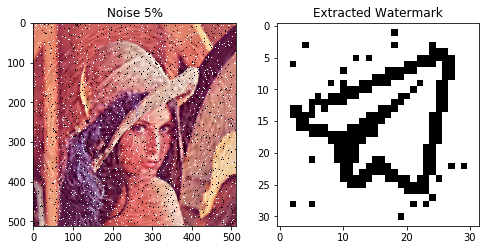

In [14]:
index = 6
(attackedImages[index], attackTitles[index]) = imgAttackedList[index]
(extractedLogos[index], extractedBers[index]) = extractWatermarkFromImage(attackedImages[index], ori_img, ori_logo, n, g, p, d, 'N={} G={} P={} D={}\n{}'.format(n, g, p, d, attackTitles[index]))

clear_output(wait = True)
print('BER = {:.0%}'.format(extractedBers[index]))
imgshow([[attackedImages[index], extractedLogos[index]]], [[attackTitles[index], 'Extracted Watermark']])

BER = 0%


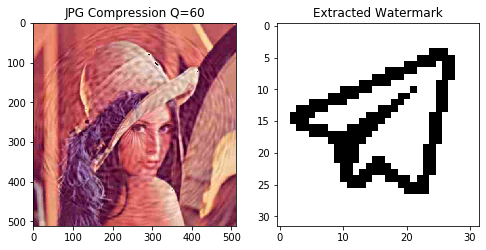

In [15]:
index = 7
(attackedImages[index], attackTitles[index]) = imgAttackedList[index]
(extractedLogos[index], extractedBers[index]) = extractWatermarkFromImage(attackedImages[index], ori_img, ori_logo, n, g, p, d, 'N={} G={} P={} D={}\n{}'.format(n, g, p, d, attackTitles[index]))

clear_output(wait = True)
print('BER = {:.0%}'.format(extractedBers[index]))
imgshow([[attackedImages[index], extractedLogos[index]]], [[attackTitles[index], 'Extracted Watermark']])

In [55]:
print(tabulate(
    [
        attackTitles,
        extractedBers
    ],
    tablefmt='orgtbl'
))

| No Attack | Rotation 45° CW | Scaling 75% | Translation X=5% Y=-5% | Crop 5% | Blur K=3 | Noise 5% | JPG Compression Q=60 |
| 0%        | 11%             | 0%          | 15%                    | 8%      | 0%       | 3%       | 0%                   |
